In [116]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.merge import merge

In [121]:
# function to load biomass data
def load_satellite_data(year=None, folder="raw", shape=None, resolution=250, delta=None):
    
    
    path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/satellite/" 

    path_bios = []
    for ending in ["0000000000-0000000000", "0000000000-0000013568"]:
        path_bios.append(path_bio + f"mosaic-{year}-{ending}.tif")

    src_files_to_mosaic = []
    for fp in path_bios:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge(src_files_to_mosaic)
    bio_data = torch.from_numpy(mosaic)
    return bio_data, out_trans
    
    nodata = 255

    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read()
    bio_data = torch.from_numpy(bio_data)
    if delta is not None:
        diff_x = int((bio_data.shape[1]%delta)/2 + delta)
        diff_y = int((bio_data.shape[0]%delta)/2 + delta)
        bio_data = torch.nn.functional.pad(bio_data, (diff_y, diff_y, diff_x, diff_x), value=nodata)
    return bio_data, out_meta

In [122]:
satellite_data, meta = load_satellite_data(year=2015, shape=None)

In [123]:
satellite_data = satellite_data.moveaxis(0, -1)

In [125]:
for i in range(6):
    print((torch.max(satellite_data[:,:,i]) * 0.1).type(torch.uint8))

tensor(6, dtype=torch.uint8)
tensor(201, dtype=torch.uint8)
tensor(197, dtype=torch.uint8)
tensor(136, dtype=torch.uint8)
tensor(146, dtype=torch.uint8)
tensor(165, dtype=torch.uint8)


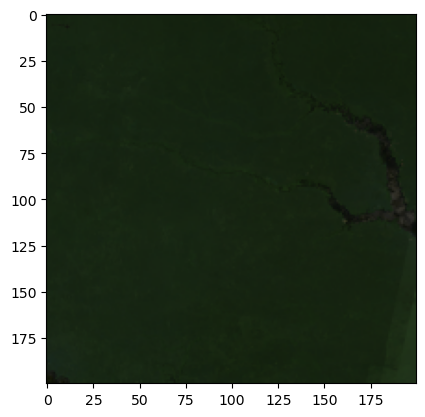

In [128]:
plt.imshow((satellite_data[5000:5200,5000:5200,[2,1,0]]*0.1).type(torch.uint8))
plt.show()

In [129]:
import geopandas as gpd
path = "../data/raw/biomass/Biomas_250mil/lm_bioma_250.shp"
df = gpd.read_file(path)
df['area_6933'] = df.geometry.to_crs("EPSG:6933").area / 10000

In [138]:
# function to load biomass data
def load_satellite_data(year=None, folder="raw", shape=None, resolution=250, delta=None):
    
    
    path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/satellite/" 

    path_bios = []
    for ending in ["0000000000-0000000000", "0000000000-0000013568"]:
        path_bios.append(path_bio + f"mosaic-{year}-{ending}.tif")

    path_bio = path_bios[0]
    
    nodata = 255

    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            # bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read()
    bio_data = torch.from_numpy(bio_data)
    if delta is not None:
        diff_x = int((bio_data.shape[1]%delta)/2 + delta)
        diff_y = int((bio_data.shape[0]%delta)/2 + delta)
        bio_data = torch.nn.functional.pad(bio_data, (diff_y, diff_y, diff_x, diff_x), value=nodata)
    return bio_data, out_meta

In [139]:
satellite_data, meta = load_satellite_data(year=2015, shape=[df.geometry[0]])
satellite_data = satellite_data.moveaxis(0, -1)

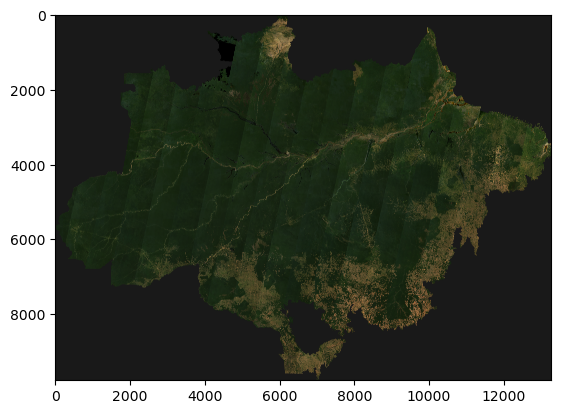

In [142]:
plt.imshow((satellite_data[:,:,[2,1,0]]*0.1).type(torch.uint8))
plt.show()